### Variants of Map and Reduce
In this notebook I want to:
1. study the difference between `map`, `fold` and `aggregate` and [combineByKey](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap) especially as it pertains to issues of execution plans and execution efficiency. Still to find a clear explanation of `numPartitions=None, partitionFunc`
2. Controlling the number of partitions using the parameter `partitionNo` and the methods `repartition` and `coalesce`
2. Controlling the RDD allocation using `cache`, `checkpoint` and the like

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
## This is a time-stamp that will be used later to identify the relevant lines in the system monitoring files.
from time import time
t_start=time()
print 'we started at time:',t_start

we started at time: 1458189302.67


In [3]:
%%time
RDD=sc.parallelize(range(100000))

CPU times: user 9.95 ms, sys: 3.8 ms, total: 13.7 ms
Wall time: 364 ms


### setting up the mapper
To demonstrate the effect of lazy execution we define a dummy function which takes significant amount of time to compute.

In [4]:
from math import cos
def taketime(i):
    [cos(i) for i in range(1000)]
    return cos(i)

In [5]:
%%time
taketime(5)

CPU times: user 609 µs, sys: 724 µs, total: 1.33 ms
Wall time: 681 µs


0.9996498529808264

### Lazy execution
we define the map-reduce operation in two steps. First, we define the map operation. Note that at this step nothin is actually executed. the command takes very little time

In [6]:
%%time
A=RDD.map(lambda x: taketime(x))

CPU times: user 26 µs, sys: 20 µs, total: 46 µs
Wall time: 47 µs


Now we execute the reduce command. As the reduce command generates an output that is not an RDD, we cannot be lazy any longer. We now have to execute the whole plan, which takes a significant amount of time.

Note that the CPU time is a tiny fraction of the wall-time required. That is because most of the time is spent waiting for data from memory to be loaded into the CPU cache.

In [7]:
%%time
A.reduce(lambda x,y:x+y)

CPU times: user 10.3 ms, sys: 4.78 ms, total: 15.1 ms
Wall time: 9.5 s


99964.98529800773

### Sharing intermediate results
The bnefit of the lazy execution plan used by Spark is that only a single pass over the RDD is required, **and** that intermediate results are not stored.

However, this advantage has a downside, Suppose that the output of the map operation when calculating the result above is also the input for a different map-reduce plan. As the map operation is executed on the fly and it's output is not stored, we have no choice but to re-execute the `map` operation.

Note that we have a variable `A` which points to the map operation. However, this variable only points to the **execution plan** for computing an RDD, and not to an RDD residing in memory.

In [8]:
%%time
print 'out=',A.filter(lambda x:x>0).count()

out= 100000
CPU times: user 8.39 ms, sys: 3.46 ms, total: 11.9 ms
Wall time: 8.57 s


### Caching
In order not to recalculate the map operation, we need to keep the intermediate result in memory. Often spark will identify shared intermediate results on it's own. In other cases we need to use either `cache()` or `persist()`.

Man pages for these commands can be found here:
* [cache](http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=cache#pyspark.RDD.cache)
* [persist](http://spark.apache.org/docs/latest/api/python/pyspark.html?highlight=persist#pyspark.RDD.persist)

Using these commands the programmer can tell spark to store the intermediate result RDD in memory (this is sometimes
called **materializing** the RDD plan). Subsequent references to the same RDD will not need to recompute the intermediate result.

Note that the cache() command does not cause the actual computation to start. Rather, it is part of the execution plan which states that **whenever** the plan is executed, the intermediate results need to be saved.

Therefor the initial `map` command still takes very short time.

In [9]:
%%time
Interm=RDD.map(lambda x: taketime(x)).cache()

CPU times: user 3.19 ms, sys: 1.51 ms, total: 4.69 ms
Wall time: 8.8 ms


In [10]:
%%time
print 'out=',Interm.reduce(lambda x,y:x+y)

out= 99964.985298
CPU times: user 8.24 ms, sys: 3.44 ms, total: 11.7 ms
Wall time: 8.19 s


The first map-reduce execution takes about the same amount of time as before

But when we execute the second command the execution time is much shorter.

In [11]:
%%time
print 'out=',Interm.filter(lambda x:x>0).count()
t_end=time()

out= 100000
CPU times: user 5.08 ms, sys: 2.21 ms, total: 7.29 ms
Wall time: 95.3 ms


### Read the logs

In [13]:
import sys
sys.path.append('../../lib/')
from combineLogs import combineLogs

df=combineLogs(t_start,t_end)

In [14]:
df.columns

Index([u'driver.BlockManager.disk.diskSpaceUsed_MB.value',
       u'driver.BlockManager.memory.maxMem_MB.value',
       u'driver.BlockManager.memory.memUsed_MB.value',
       u'driver.BlockManager.memory.remainingMem_MB.value',
       u'driver.DAGScheduler.job.activeJobs.value',
       u'driver.DAGScheduler.job.allJobs.value',
       u'driver.DAGScheduler.messageProcessingTime.count',
       u'driver.DAGScheduler.messageProcessingTime.duration_unit',
       u'driver.DAGScheduler.messageProcessingTime.m15_rate',
       u'driver.DAGScheduler.messageProcessingTime.m1_rate',
       u'driver.DAGScheduler.messageProcessingTime.m5_rate',
       u'driver.DAGScheduler.messageProcessingTime.max',
       u'driver.DAGScheduler.messageProcessingTime.mean',
       u'driver.DAGScheduler.messageProcessingTime.mean_rate',
       u'driver.DAGScheduler.messageProcessingTime.min',
       u'driver.DAGScheduler.messageProcessingTime.p50',
       u'driver.DAGScheduler.messageProcessingTime.p75',
       u'dri

In [15]:
cols=[name for name in df.columns if ('messageProcessing' in name) and ('rate' in name)]
cols

['driver.DAGScheduler.messageProcessingTime.m15_rate',
 'driver.DAGScheduler.messageProcessingTime.m1_rate',
 'driver.DAGScheduler.messageProcessingTime.m5_rate',
 'driver.DAGScheduler.messageProcessingTime.mean_rate',
 'driver.DAGScheduler.messageProcessingTime.rate_unit']

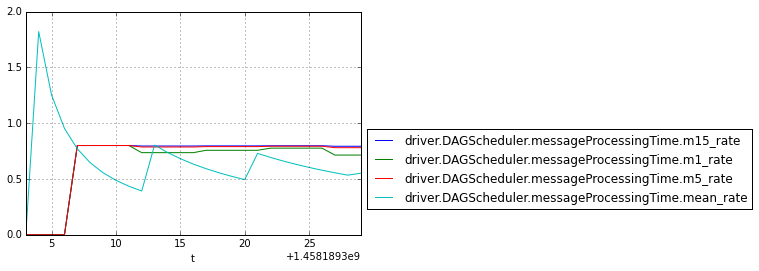

In [16]:
f = plt.figure()
df[cols].plot(ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

In [17]:
!tail /private/tmp/sparklog.txt

16/03/16 21:37:07 INFO BlockManager: Reporting 2 blocks to the master.
16/03/16 21:37:07 INFO BlockManagerInfo: Added rdd_3_1 in memory on localhost:58699 (size: 21.2 KB, free: 511.1 MB)
16/03/16 21:37:07 INFO BlockManagerInfo: Added rdd_3_0 in memory on localhost:58699 (size: 21.3 KB, free: 511.1 MB)
16/03/16 21:37:17 INFO Executor: Told to re-register on heartbeat
16/03/16 21:37:17 INFO BlockManager: BlockManager re-registering with master
16/03/16 21:37:17 INFO BlockManagerMaster: Trying to register BlockManager
16/03/16 21:37:17 INFO BlockManagerMaster: Registered BlockManager
16/03/16 21:37:17 INFO BlockManager: Reporting 2 blocks to the master.
16/03/16 21:37:17 INFO BlockManagerInfo: Added rdd_3_1 in memory on localhost:58699 (size: 21.2 KB, free: 511.1 MB)
16/03/16 21:37:17 INFO BlockManagerInfo: Added rdd_3_0 in memory on localhost:58699 (size: 21.3 KB, free: 511.1 MB)
